In [ ]:
# make connection to google drive to access data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# set up directory paths to image files
train_path = "/content/drive/My Drive/Deep Learning and Generative AI/C-NMC_Leukemia/training_data/fold_0"
test_path = "/content/drive/My Drive/Deep Learning and Generative AI/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data"
val_path = "/content/drive/My Drive/Deep Learning and Generative AI/C-NMC_Leukemia/validation_data"

In [ ]:
# import relevant libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

%matplotlib inline

In [ ]:
from PIL import Image

healthy_imgs = []
for file in os.listdir(train_path + "/hem"):
  img_path = os.path.join(train_path, "hem", file)

  # load and convert to grayscale
  img = Image.open(img_path).convert("L") # "L" mode = Grayscale
  img = img.resize((224, 224)) # resize to 45x45
  healthy_imgs.append(img)

healthy_imgs = np.array(healthy_imgs, dtype=np.float32) / 127.5 - 1.0 # normalize
healthy_imgs = np.expand_dims(np.array(healthy_imgs), axis=-1)

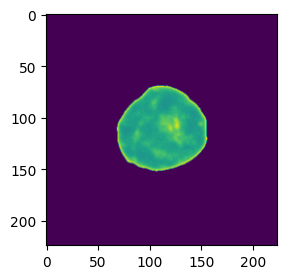

In [ ]:
plt.figure(figsize=(4,3))
plt.imshow(healthy_imgs[0])

In [ ]:
healthy_imgs.shape

(1130, 224, 224, 1)

In [ ]:
healthy_imgs.min()

-1.0

In [ ]:
healthy_imgs.max()

0.12156868

## Filtering out the Data for Faster Training on Smaller Dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose,Cropping2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
codings_size = 500

In [ ]:
generator = Sequential()

# start with a Dense layer and reshape to 7x7x128
generator.add(Dense(7 * 7 * 128, input_shape=[codings_size]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())

# first upsampling: 7x7 -> 14x14
generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())

# second upsampling: 14x14 -> 28x28
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())

# third upsampling: 28x28 -> 56x56
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())

# fourth upsampling: 56x56 -> 112x112
generator.add(Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())

# fifth upsampling: 112x112 -> 224x224
generator.add(Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())

# output layer
generator.add(Conv2DTranspose(1, kernel_size=5, strides=1, padding="same", activation="tanh"))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
discriminator = Sequential()

discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3), input_shape=[224, 224, 1]))
discriminator.add(Dropout(0.5))

discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))

discriminator.add(Flatten())

discriminator.add(Dense(1, activation="sigmoid"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
GAN = Sequential([generator, discriminator])

In [ ]:
optimizer = Adam(learning_rate=0.0002,beta_1=0.5,clipvalue=1.5)
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer)
discriminator.trainable = False

In [ ]:
optimizer = Adam(learning_rate=0.0001,beta_1=0.5)
GAN.compile(loss="binary_crossentropy", optimizer=optimizer)

In [ ]:
GAN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 1)         │       3,938,785 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │         608,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,546,786 (17.34 MB)

 Trainable params: 3,937,889 (15.02 MB)

 Non-trainable params: 608,897 (2.32 MB)

In [ ]:
GAN.layers[0].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6272)                │       3,142,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 56, 56, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 112, 112, 32)        │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 224, 224, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 224, 224, 1)         │             801 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,938,785 (15.03 MB)

 Trainable params: 3,937,889 (15.02 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
GAN.layers[1].summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 112, 112, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 56, 56, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │         401,409 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 608,001 (2.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 608,001 (2.32 MB)

In [ ]:
def epoch_plot(ep):
    noise = tf.random.normal(shape=[10, codings_size])
    images = generator(noise)
    plt.figure(figsize=(4,3))
    plt.imshow(images[0].numpy().reshape(224,224,1))
    plt.title('Epoch {}'.format(ep+1),fontsize=14)
    plt.show()

In [ ]:
def plot_losses(d_losses, g_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label="Discriminator Loss", color='red')
    plt.plot(g_losses, label="Generator Loss", color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Losses during GAN training")
    plt.grid(True)
    # plt.savefig("gan_loss_plot.png")
    plt.show()

### Setting up Training Batches

In [ ]:
import tensorflow as tf

In [ ]:
batch_size = 32

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(healthy_imgs).shuffle(buffer_size=1000)

In [ ]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
epochs = 300

Currently on Epoch 1
Discriminator Loss: 0.0931	Generator Loss: 3.2582


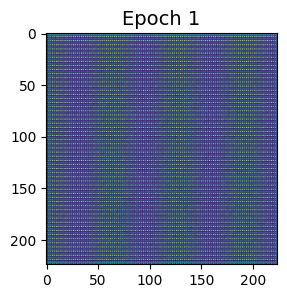

Currently on Epoch 2
Currently on Epoch 3
Currently on Epoch 4
Currently on Epoch 5
Currently on Epoch 6
Currently on Epoch 7
Currently on Epoch 8
Currently on Epoch 9
Currently on Epoch 10
Currently on Epoch 11
Currently on Epoch 12
Currently on Epoch 13
Currently on Epoch 14
Currently on Epoch 15
Currently on Epoch 16
Currently on Epoch 17
Currently on Epoch 18
Currently on Epoch 19
Currently on Epoch 20
Currently on Epoch 21
Currently on Epoch 22
Currently on Epoch 23
Currently on Epoch 24
Currently on Epoch 25
Currently on Epoch 26
Currently on Epoch 27
Currently on Epoch 28
Currently on Epoch 29
Currently on Epoch 30
Currently on Epoch 31
Currently on Epoch 32
Currently on Epoch 33
Currently on Epoch 34
Currently on Epoch 35
Currently on Epoch 36
Currently on Epoch 37
Currently on Epoch 38
Currently on Epoch 39
Currently on Epoch 40
Currently on Epoch 41
Currently on Epoch 42
Currently on Epoch 43
Currently on Epoch 44
Currently on Epoch 45
Currently on Epoch 46
Currently on Epoch

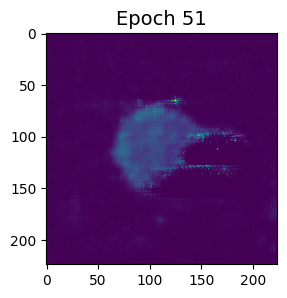

Currently on Epoch 52
Currently on Epoch 53
Currently on Epoch 54
Currently on Epoch 55
Currently on Epoch 56
Currently on Epoch 57
Currently on Epoch 58
Currently on Epoch 59
Currently on Epoch 60
Currently on Epoch 61
Currently on Epoch 62
Currently on Epoch 63
Currently on Epoch 64
Currently on Epoch 65
Currently on Epoch 66
Currently on Epoch 67
Currently on Epoch 68
Currently on Epoch 69
Currently on Epoch 70
Currently on Epoch 71
Currently on Epoch 72
Currently on Epoch 73
Currently on Epoch 74
Currently on Epoch 75
Currently on Epoch 76
Currently on Epoch 77
Currently on Epoch 78
Currently on Epoch 79
Currently on Epoch 80
Currently on Epoch 81
Currently on Epoch 82
Currently on Epoch 83
Currently on Epoch 84
Currently on Epoch 85
Currently on Epoch 86
Currently on Epoch 87
Currently on Epoch 88
Currently on Epoch 89
Currently on Epoch 90
Currently on Epoch 91
Currently on Epoch 92
Currently on Epoch 93
Currently on Epoch 94
Currently on Epoch 95
Currently on Epoch 96
Currently 

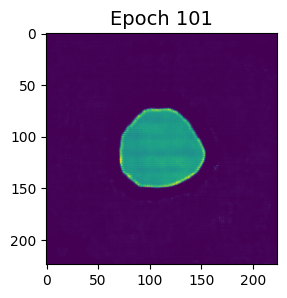

Currently on Epoch 102
Currently on Epoch 103
Currently on Epoch 104
Currently on Epoch 105
Currently on Epoch 106
Currently on Epoch 107
Currently on Epoch 108
Currently on Epoch 109
Currently on Epoch 110
Currently on Epoch 111
Currently on Epoch 112
Currently on Epoch 113
Currently on Epoch 114
Currently on Epoch 115
Currently on Epoch 116
Currently on Epoch 117
Currently on Epoch 118
Currently on Epoch 119
Currently on Epoch 120
Currently on Epoch 121
Currently on Epoch 122
Currently on Epoch 123
Currently on Epoch 124
Currently on Epoch 125
Currently on Epoch 126
Currently on Epoch 127
Currently on Epoch 128
Currently on Epoch 129
Currently on Epoch 130
Currently on Epoch 131
Currently on Epoch 132
Currently on Epoch 133
Currently on Epoch 134
Currently on Epoch 135
Currently on Epoch 136
Currently on Epoch 137
Currently on Epoch 138
Currently on Epoch 139
Currently on Epoch 140
Currently on Epoch 141
Currently on Epoch 142
Currently on Epoch 143
Currently on Epoch 144
Currently o

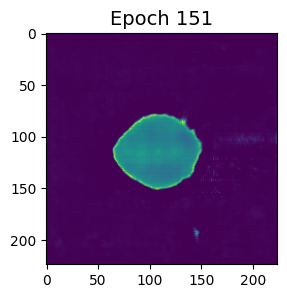

Currently on Epoch 152
Currently on Epoch 153
Currently on Epoch 154
Currently on Epoch 155
Currently on Epoch 156
Currently on Epoch 157
Currently on Epoch 158
Currently on Epoch 159
Currently on Epoch 160
Currently on Epoch 161
Currently on Epoch 162
Currently on Epoch 163
Currently on Epoch 164
Currently on Epoch 165
Currently on Epoch 166
Currently on Epoch 167
Currently on Epoch 168
Currently on Epoch 169
Currently on Epoch 170
Currently on Epoch 171
Currently on Epoch 172
Currently on Epoch 173
Currently on Epoch 174
Currently on Epoch 175
Currently on Epoch 176
Currently on Epoch 177
Currently on Epoch 178
Currently on Epoch 179
Currently on Epoch 180
Currently on Epoch 181
Currently on Epoch 182
Currently on Epoch 183
Currently on Epoch 184
Currently on Epoch 185
Currently on Epoch 186
Currently on Epoch 187
Currently on Epoch 188
Currently on Epoch 189
Currently on Epoch 190
Currently on Epoch 191
Currently on Epoch 192
Currently on Epoch 193
Currently on Epoch 194
Currently o

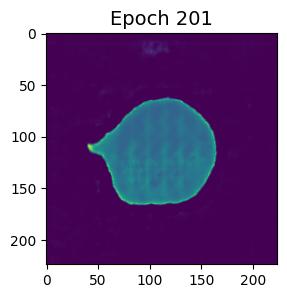

Currently on Epoch 202
Currently on Epoch 203
Currently on Epoch 204
Currently on Epoch 205
Currently on Epoch 206
Currently on Epoch 207
Currently on Epoch 208
Currently on Epoch 209
Currently on Epoch 210
Currently on Epoch 211
Currently on Epoch 212
Currently on Epoch 213
Currently on Epoch 214
Currently on Epoch 215
Currently on Epoch 216
Currently on Epoch 217
Currently on Epoch 218
Currently on Epoch 219
Currently on Epoch 220
Currently on Epoch 221
Currently on Epoch 222
Currently on Epoch 223
Currently on Epoch 224
Currently on Epoch 225
Currently on Epoch 226
Currently on Epoch 227
Currently on Epoch 228
Currently on Epoch 229
Currently on Epoch 230
Currently on Epoch 231
Currently on Epoch 232
Currently on Epoch 233
Currently on Epoch 234
Currently on Epoch 235
Currently on Epoch 236
Currently on Epoch 237
Currently on Epoch 238
Currently on Epoch 239
Currently on Epoch 240
Currently on Epoch 241
Currently on Epoch 242
Currently on Epoch 243
Currently on Epoch 244
Currently o

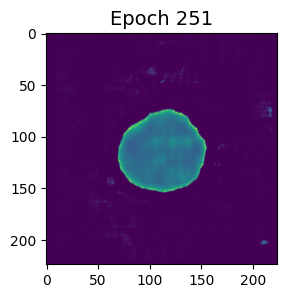

Currently on Epoch 252
Currently on Epoch 253
Currently on Epoch 254
Currently on Epoch 255
Currently on Epoch 256
Currently on Epoch 257
Currently on Epoch 258
Currently on Epoch 259
Currently on Epoch 260
Currently on Epoch 261
Currently on Epoch 262
Currently on Epoch 263
Currently on Epoch 264
Currently on Epoch 265
Currently on Epoch 266
Currently on Epoch 267
Currently on Epoch 268
Currently on Epoch 269
Currently on Epoch 270
Currently on Epoch 271
Currently on Epoch 272
Currently on Epoch 273
Currently on Epoch 274
Currently on Epoch 275
Currently on Epoch 276
Currently on Epoch 277
Currently on Epoch 278
Currently on Epoch 279
Currently on Epoch 280
Currently on Epoch 281
Currently on Epoch 282
Currently on Epoch 283
Currently on Epoch 284
Currently on Epoch 285
Currently on Epoch 286
Currently on Epoch 287
Currently on Epoch 288
Currently on Epoch 289
Currently on Epoch 290
Currently on Epoch 291
Currently on Epoch 292
Currently on Epoch 293
Currently on Epoch 294
Currently o

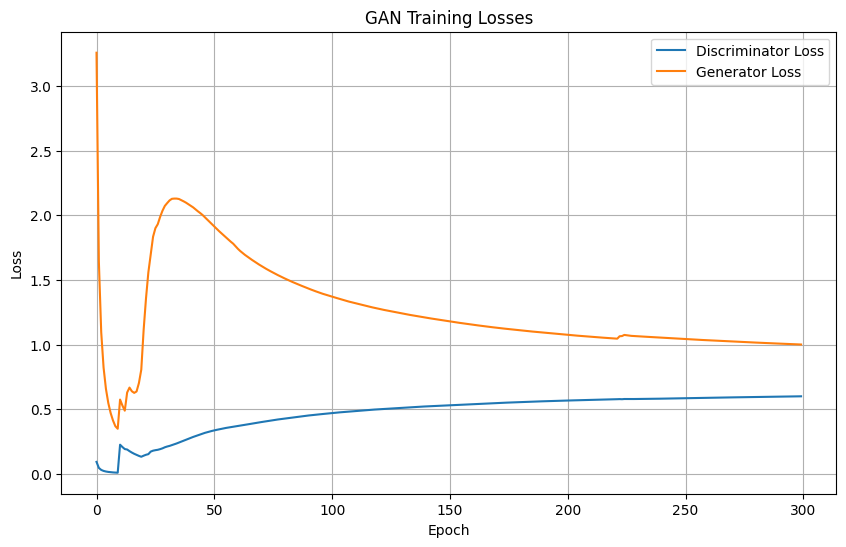


*****Training Completed!*****



In [ ]:
# grab the seprate components
generator, discriminator = GAN.layers

d_losses = [] # list to track discriminator losses
g_losses = [] # list to track generator losses

for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")

    i = 0
    for X_batch in dataset:

        # training the discriminator
        epoch_d_losses = [] # track losses for each epoch
        epoch_g_losses = [] # track losses for each epoch

        noise = tf.random.normal(shape=[batch_size, codings_size]) # create noise

        gen_images = generator(noise) # generate based on noise

        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0) # join generated against the real

        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) # target - zero for fake and one for real

        discriminator.trainable = True

        d_loss = discriminator.train_on_batch(X_fake_vs_real, y1) # train discriminator

        epoch_d_losses.append(d_loss)

        # training the generator
        noise = tf.random.normal(shape=[batch_size, codings_size]) # create noise

        y2 = tf.constant([[1.]] * batch_size) # discriminator belives fake are real

        discriminator.trainable = False

        g_loss = GAN.train_on_batch(noise, y2) # train generator

        epoch_g_losses.append(g_loss)

    # calculate average losses for this epoch
    avg_d_loss = np.mean(epoch_d_losses)
    avg_g_loss = np.mean(epoch_g_losses)

    # store the average losses
    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)

    if epoch % 50 == 0: # print every 50 epochs
      print(f"Discriminator Loss: {avg_d_loss:.4f}\tGenerator Loss: {avg_g_loss:.4f}") # print current loss values for GAN
      epoch_plot(epoch) # plot example image based on trained generator

# plot losses - post training
print("\n")
plt.figure(figsize=(10, 6))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.grid(True)
plt.show()

print("\n*****Training Completed!*****\n")

In [ ]:
noise = tf.random.normal(shape=[10, codings_size]) # example noise to test generator after training

In [ ]:
images = generator(noise) # get images based on trained generator

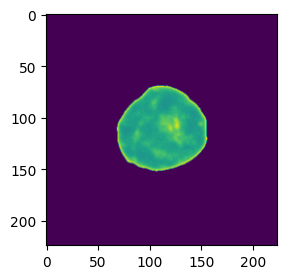

In [ ]:
plt.figure(figsize=(4,3))
plt.imshow(healthy_imgs[0]) # show example of expected generator output

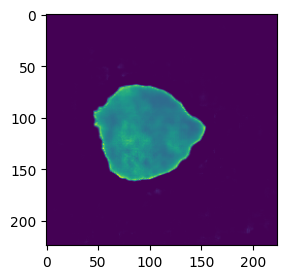

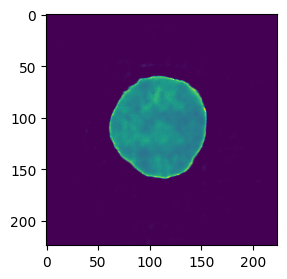

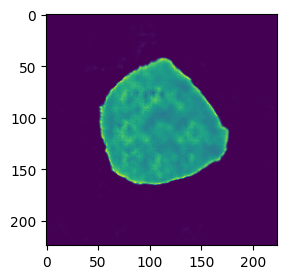

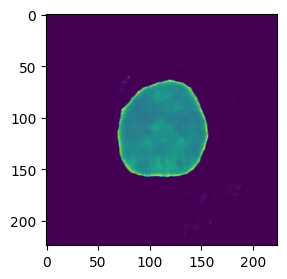

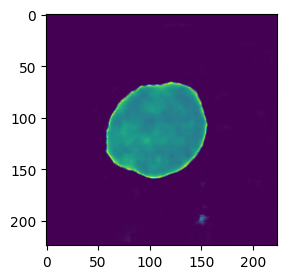

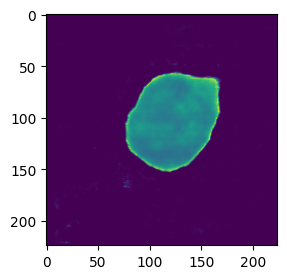

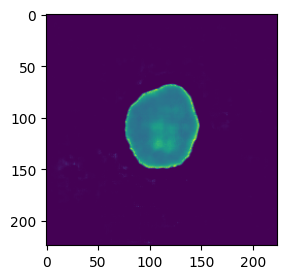

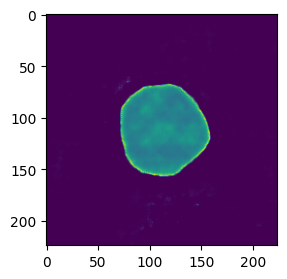

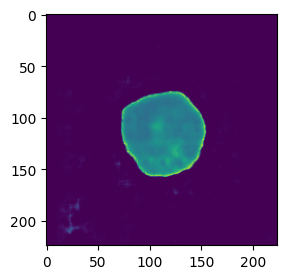

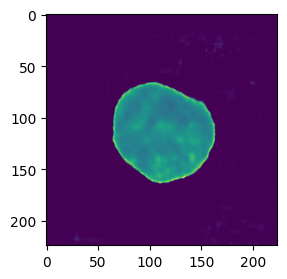

In [ ]:
# loop to plot generated images
for image in images:
    plt.figure(figsize=(4,3))
    plt.imshow(image.numpy().reshape(224,224,1))
    plt.show()
    print("\n")